In [7]:
import sys, os
import numpy as np
import glob
import datetime
import json
import ipdb
deb = ipdb.set_trace

# MRI analysis imports
from prfpy.stimulus import PRFStimulus2D
from prfpy.model import Iso2DGaussianModel, Norm_Iso2DGaussianModel
from prfpy.fit import Iso2DGaussianFitter, Norm_Iso2DGaussianFitter
import nibabel as nb

sys.path.append("{}/../../../utils".format(os.getcwd()))
from surface_utils import make_surface_image , load_surface


In [30]:
subject = 'sub-02'
# dir_data = '/home/mszinte/disks/meso_S/data/RetinoMaps'
# dir_code = '/home/mszinte/disks/meso_H/projects/RetinoMaps'

dir_data = '/Users/uriel/disks/meso_shared/RetinoMaps'
dir_code = '/Users/uriel/disks/meso_H/projects/RetinoMaps'

input_vd = '{}/derivatives/vdm/vdm.npy'.format(dir_data)
input_fn_fsnative = '{}/derivatives/pp_data/{}/func/fmriprep_dct_avg/fsnative/{}_task-pRF_hemi-L_fmriprep_dct_avg_bold.func.gii'.format(
    dir_data, subject, subject)

# Analysis parameters
with open('{}/analysis_code/settings.json'.format(dir_code)) as f:
    json_s = f.read()
    analysis_info = json.loads(json_s)
screen_size_cm = analysis_info['screen_size_cm']
screen_distance_cm = analysis_info['screen_distance_cm']
TR = analysis_info['TR']
gauss_grid_nr = analysis_info['gauss_grid_nr']
dn_grid_nr = analysis_info['dn_grid_nr']
max_ecc_size = analysis_info['max_ecc_size']
n_jobs = 32
n_batches = 32
xtol = 1e-4
ftol = 1e-4
rsq_threshold = 0.01
verbose = False

In [90]:
# defind pRF parameter range
sizes = max_ecc_size * np.linspace(0.1,1,gauss_grid_nr)**2
eccs = max_ecc_size * np.linspace(0.25,1,gauss_grid_nr)**2
polars = np.linspace(0, 2*np.pi, gauss_grid_nr)

# defind dn parameters
fixed_grid_baseline = 0

gauss_grid_bounds = [(0,1000)] #only prf amplitudes between 0 and 1000
dn_grid_bounds = [(0,1000),(0,1000)] #only prf amplitudes between 0 and 1000, only neural baseline values between 0 and 1000

surround_size_grid = max_ecc_size * np.linspace(0.1, 1, dn_grid_nr)**2
surround_amplitude_grid = np.linspace(0, 10, dn_grid_nr)
surround_baseline_grid = np.linspace(0, 10, dn_grid_nr)
neural_baseline_grid = np.linspace(0, 10, dn_grid_nr)





gauss_bounds = [(-1.5*max_ecc_size, 1.5*max_ecc_size),  # x
                (-1.5*max_ecc_size, 1.5*max_ecc_size),  # y
                (0.01, 1.5*max_ecc_size),# prf size
                (0, 1000),  # prf amplitude
                (0, 1000),# bold baseline
                (0,9),(0,0)]  #hrf bounds


norm_bounds = [(-1.5*max_ecc_size, 1.5*max_ecc_size),  # x
                (-1.5*max_ecc_size, 1.5*max_ecc_size),  # y
                (0.01, 1.5*max_ecc_size),  # prf size
                (0, 1000),  # prf amplitude
                (0, 1000),  # bold baseline
                (0, 1000),  # surround amplitude
                (0.1, 3*max_ecc_size),  # surround size
                (0, 1000),  # neural baseline
                (1e-6, 1000),# surround baseline
                (0,10),(0,0)]  #hrf bounds


In [14]:
vdm = np.load(input_vd)
# Load fsnative data 
data_img_fsnative, data_fsnative = load_surface(input_fn_fsnative)


In [17]:
# Create subsample of data
data = data_fsnative[:,0:10]
#data_fsnative_ = data_fsnative[:,0:80000]

In [6]:
# compute how much data is pick from the full amount
data_fsnative_.shape[1]/data_fsnative.shape[1]

0.0067742416236502324

In [14]:
# # Check and plot the variance of the vertices
# data_var = np.var(data_fsnative_,axis=0)

# import plotly.figure_factory as ff
# import numpy as np

# x = data_var
# hist_data = [x]
# group_labels = ['variance'] # name of the dataset

# fig = ff.create_distplot(hist_data, group_labels,bin_size=.1)
# fig.show()

In [31]:
# determine gauss model
stimulus = PRFStimulus2D(screen_size_cm=screen_size_cm[1], 
                         screen_distance_cm=screen_distance_cm,
                         design_matrix=vdm, 
                         TR=TR)
gauss_model = Iso2DGaussianModel(stimulus=stimulus)

# grid fit gauss model
gauss_fitter = Iso2DGaussianFitter(data=data.T, model=gauss_model, n_jobs=n_jobs)


gauss_fitter.grid_fit(ecc_grid=eccs, 
                      polar_grid=polars, 
                      size_grid=sizes, 
                      grid_bounds=gauss_grid_bounds,
                      verbose=verbose, 
                      n_batches=n_batches)


/Users/uriel/softwares/anaconda3/envs/amblyo_env/prfpy/prfpy/fit.py:441: RuntimeWarning: divide by zero encountered in divide
  slopes = (n_timepoints * np.dot(vox_data, predictions.T) - sumd *
/Users/uriel/softwares/anaconda3/envs/amblyo_env/prfpy/prfpy/fit.py:441: RuntimeWarning: invalid value encountered in divide
  slopes = (n_timepoints * np.dot(vox_data, predictions.T) - sumd *
/Users/uriel/softwares/anaconda3/envs/amblyo_env/prfpy/prfpy/fit.py:450: RuntimeWarning: invalid value encountered in multiply
  slopes[..., np.newaxis] *
/Users/uriel/softwares/anaconda3/envs/amblyo_env/prfpy/prfpy/fit.py:449: RuntimeWarning: invalid value encountered in subtract
  resid = np.linalg.norm((vox_data -
/Users/uriel/softwares/anaconda3/envs/amblyo_env/prfpy/prfpy/fit.py:441: RuntimeWarning: divide by zero encountered in divide
  slopes = (n_timepoints * np.dot(vox_data, predictions.T) - sumd *
/Users/uriel/softwares/anaconda3/envs/amblyo_env/prfpy/prfpy/fit.py:441: RuntimeWarning: invalid val

In [91]:
# iterative fit
gauss_fitter.iterative_fit(rsq_threshold=rsq_threshold, 
                           verbose=verbose,
                           bounds = gauss_bounds,
                           xtol=1e-4,
                           ftol=1e-4)
gauss_fit = gauss_fitter.iterative_search_params

In [92]:
gauss_fit_mat = np.zeros((data_fsnative_.shape[1],8))
gauss_pred_mat = np.zeros_like(data_fsnative_) 
for est in range(len(data_fsnative_.T)):
    gauss_fit_mat[est] = gauss_fit[est]
    gauss_pred_mat[:,est] = gauss_model.return_prediction(mu_x=gauss_fit[est][0], 
                                                          mu_y=gauss_fit[est][1], 
                                                          size=gauss_fit[est][2], 
                                                          beta=gauss_fit[est][3], 
                                                          baseline=gauss_fit[est][4])

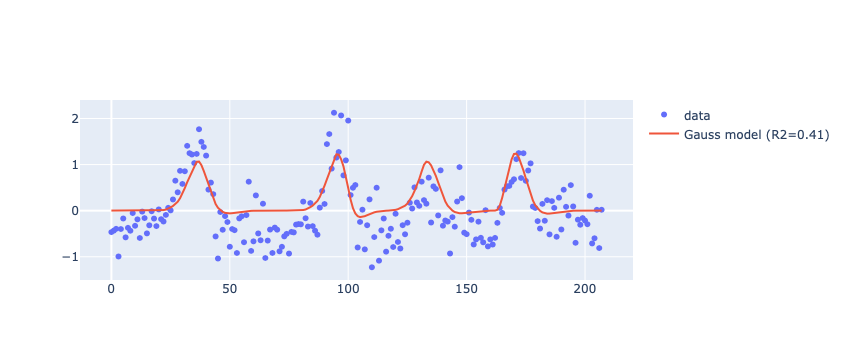

In [93]:
num_vert = 1
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(y=data_fsnative_[:,num_vert], name='data', mode='markers'))
fig.add_trace(go.Scatter(y=gauss_pred_mat[:,num_vert], name='Gauss model (R2={:1.2f})'.format(gauss_fit_mat[num_vert,-1])))
fig.show()

In [69]:
# determine DN model
dn_model = Norm_Iso2DGaussianModel(stimulus=stimulus)
dn_fitter = Norm_Iso2DGaussianFitter(data=data_fsnative_.T, 
                                     model=dn_model, 
                                     n_jobs=n_jobs,
                                     use_previous_gaussian_fitter_hrf=True,
                                     previous_gaussian_fitter=gauss_fitter)

In [70]:
# dn parameters
fixed_grid_baseline = 0
grid_bounds = [(0,100),(0,100)]
surround_size_grid = sizes#max_ecc_size * np.linspace(0.1,1,dn_grid_nr)**2
surround_amplitude_grid = np.linspace(0, 10, dn_grid_nr)
surround_baseline_grid = np.linspace(0, 10, dn_grid_nr)
neural_baseline_grid = np.linspace(0, 10, dn_grid_nr)

dn_fitter.grid_fit(
    fixed_grid_baseline=fixed_grid_baseline,
    grid_bounds=grid_bounds,
    surround_amplitude_grid=surround_amplitude_grid,
    surround_size_grid=surround_size_grid,             
    surround_baseline_grid=surround_baseline_grid,
    neural_baseline_grid=neural_baseline_grid,
    n_batches=n_batches,
    rsq_threshold=rsq_threshold,
    verbose=verbose,
    # hrf_1_grid=np.linspace(0,10,num),
    # hrf_2_grid=np.linspace(0,0,1)
)

Using HRF from previous gaussian iterative fit


[Parallel(n_jobs=32)]: Using backend LokyBackend with 32 concurrent workers.
/Users/uriel/softwares/anaconda3/envs/amblyo_env/prfpy/prfpy/model.py:607: RuntimeWarning: divide by zero encountered in divide
  tc = self.convolve_timecourse_hrf(((prf_amplitude[..., np.newaxis] * activation_part + neural_baseline[..., np.newaxis]) /\
/Users/uriel/softwares/anaconda3/envs/amblyo_env/prfpy/prfpy/model.py:609: RuntimeWarning: divide by zero encountered in divide
  - neural_baseline[..., np.newaxis]/surround_baseline[..., np.newaxis]).astype('float32')
/Users/uriel/softwares/anaconda3/envs/amblyo_env/prfpy/prfpy/model.py:609: RuntimeWarning: invalid value encountered in divide
  - neural_baseline[..., np.newaxis]/surround_baseline[..., np.newaxis]).astype('float32')
/Users/uriel/softwares/anaconda3/envs/amblyo_env/prfpy/prfpy/model.py:607: RuntimeWarning: invalid value encountered in subtract
  tc = self.convolve_timecourse_hrf(((prf_amplitude[..., np.newaxis] * activation_part + neural_baselin

In [74]:
dn_fitter.iterative_fit(rsq_threshold=rsq_threshold, 
                        verbose=verbose,
                        bounds = norm_bounds,
                        xtol=xtol,
                        ftol=ftol
                       )
fit_fit_dn = dn_fitter.iterative_search_params

In [75]:
dn_fit_mat = np.zeros((data_fsnative_.shape[1],12))
dn_pred_mat = np.zeros_like(data_fsnative_) 
for est in range(len(data_fsnative_.T)):
    dn_fit_mat[est] = fit_fit_dn[est]
    dn_pred_mat[:,est] = dn_model.return_prediction(mu_x=fit_fit_dn[est][0], 
                                                    mu_y=fit_fit_dn[est][1], 
                                                    prf_size=fit_fit_dn[est][2], 
                                                    prf_amplitude=fit_fit_dn[est][3], 
                                                    bold_baseline=fit_fit_dn[est][4],
                                                    srf_amplitude=fit_fit_dn[est][5],
                                                    srf_size=fit_fit_dn[est][6],
                                                    neural_baseline=fit_fit_dn[est][7],
                                                    surround_baseline=fit_fit_dn[est][8]
                                                   )

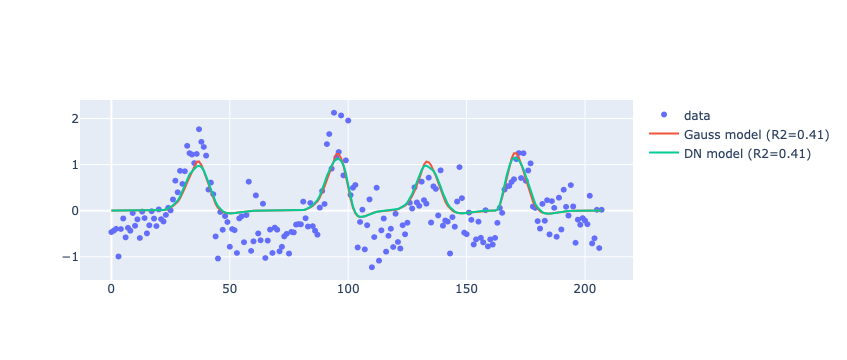

In [29]:
num_vert = 1
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(y=data_fsnative_[:,num_vert], name='data', mode='markers'))
fig.add_trace(go.Scatter(y=gauss_pred_mat[:,num_vert], name='Gauss model (R2={:1.2f})'.format(gauss_fit_mat[num_vert,-1])))
fig.add_trace(go.Scatter(y=dn_pred_mat[:,num_vert], name='DN model (R2={:1.2f})'.format(dn_fit_mat[num_vert,-1])))
fig.show()

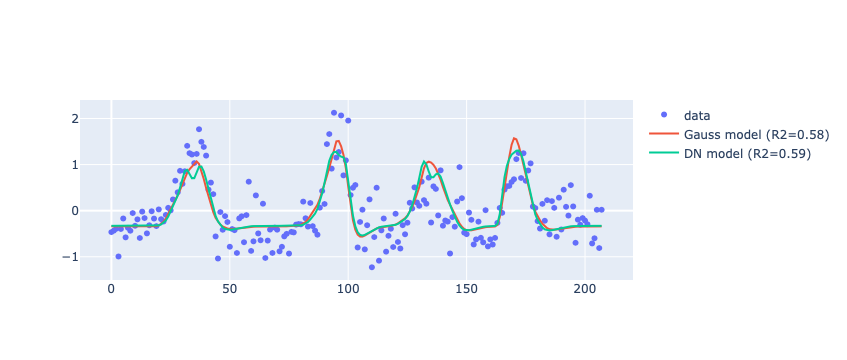

Performing bounded, unconstrained minimization (L-BFGS-B).
Performing bounded, unconstrained minimization (L-BFGS-B).


In [39]:
num_vert = 1
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(y=data_fsnative_[:,num_vert], name='data', mode='markers'))
fig.add_trace(go.Scatter(y=gauss_pred_mat[:,num_vert], name='Gauss model (R2={:1.2f})'.format(gauss_fit_mat[num_vert,-1])))
fig.add_trace(go.Scatter(y=dn_pred_mat[:,num_vert], name='DN model (R2={:1.2f})'.format(dn_fit_mat[num_vert,-1])))
fig.show()

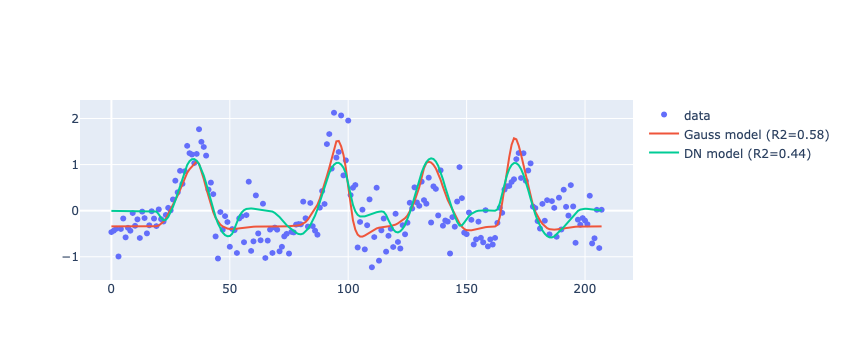

Performing unbounded, unconstrained minimization (Powell).
Optimization terminated successfully.
         Current function value: 38.881470
         Iterations: 22
         Function evaluations: 3054
Performing bounded, unconstrained minimization (L-BFGS-B).
Performing unbounded, unconstrained minimization (Powell).
Optimization terminated successfully.
         Current function value: 37.457870
         Iterations: 35
         Function evaluations: 5202
Performing unbounded, unconstrained minimization (Powell).
Optimization terminated successfully.
         Current function value: 38.276848
         Iterations: 23
         Function evaluations: 3135


In [76]:
num_vert = 1
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(y=data_fsnative_[:,num_vert], name='data', mode='markers'))
fig.add_trace(go.Scatter(y=gauss_pred_mat[:,num_vert], name='Gauss model (R2={:1.2f})'.format(gauss_fit_mat[num_vert,-1])))
fig.add_trace(go.Scatter(y=dn_pred_mat[:,num_vert], name='DN model (R2={:1.2f})'.format(dn_fit_mat[num_vert,-1])))
fig.show()